# Teste Técnico para Ciência de Dados da Keyrus

## 1ª parte: Análise Exploratória

- [x] Tipos de variáveis
- [x] Medidas de posição
- [x] Medidas de dispersão
- [x] Tratamento de Missing Values
- [x] Gráficos
- [x] Análise de Outliers

## 2ª parte: Estatística

- [x] Estatística descritiva
- [x] Identificação das distribuições das variáveis

## 3ª parte: Modelagem

- [x] Modelos de previsão
- [x] Escolha de melhor modelo
- [x] Avaliação de resultados
- [ ] Métricas

## Imports

In [2]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # missing values

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Other
from IPython.display import Image
import warnings
import os
import time
import pprint

## Preparação do Diretório Principal

In [3]:
def exit_current_directory():
    # PATH current
    path = os.getcwd()
    os.chdir('..')
    print('Current working directory:\n{}\n'.format(os.getcwd()))
    
exit_current_directory()

Current working directory:
/home/campos/projetos/challenges/challenge-keyrus



## Cell Format

In [4]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format


pp = pprint.PrettyPrinter(indent=4)

# parametros de config
rc={'savefig.dpi': 75, 
    'figure.autolayout': False, 
    'figure.figsize': [17, 5], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 10, 
    'lines.linewidth': 2.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 14,
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12}

# Print max 3000 rows and all columns
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Single colour palettes for good and bad outcomes
good_palette = ['#44cc44']
bad_palette = ['#cc4444']
# Colour palette for gender - traditional light pink (female), light blue (male)
gender_palette = ['#B0C4DE','#FFB6C1']
# Colour palette for ticket class - gold (first), silver (second), bronze (third)
class_palette = ['#FFD700','#C0C0C0','#CD7F32']

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Carregamento dos Dados

In [5]:
%%time

df_callcenter = pd.read_csv('reports/callcenter_marketing_clenning.csv', 
                            encoding='utf8',
                            delimiter=',',
                            verbose=True)

Tokenization took: 17.41 ms
Type conversion took: 31.64 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 2.69 ms
Type conversion took: 5.53 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 61.1 ms, sys: 7.33 ms, total: 68.5 ms
Wall time: 67 ms


OBS: carragamento em quase metade do tempo em realação a versão original do arquivo csv.

---

## Variáveis Globais

In [6]:
# Lists that will be manipulated in the data processing
list_columns = []
list_categorical_col = []
list_numerical_col = []
list_without_target_col = []

In [7]:
def get_col(df: 'dataframe' = None,
            type_descr: 'numpy' = np.number) -> list:
    """
    Function get list columns 
    
    Args:
    type_descr
        np.number, np.object -> return list with all columns
        np.number            -> return list numerical columns 
        np.object            -> return list object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n')    
    else:
        return col.tolist() 

In [8]:
def get_col_without_target(df: 'dataframe',
                           list_columns: list,
                           target_col: str) -> list:

    col_target = list_columns.copy()
    
    col_target.remove(target_col)
    print(type(col_target))
    
    
    return col_target

In [9]:
list_numerical_col = get_col(df=df_callcenter,
                             type_descr=np.number)
list_categorical_col = get_col(df=df_callcenter,
                               type_descr=np.object)
list_columns = get_col(df=df_callcenter,
                       type_descr=[np.object, np.number])
list_without_target_col = get_col_without_target(df=df_callcenter,
                                                 list_columns=list_columns,
                                                 target_col='resultado')

Dataframe not contains <class 'object'> columns !
<class 'list'>


---

## Feature Importance
Vou utilizar uma decision tree para fazer uma feature selection.<br/>
A partir disso, vou ranquear as features mais importantes.

**OBS:** não necessariamente utilizarei um modelo de random forest. Neste momento só estou usando para descobrir quais são as variáveis de maior peso no modelo.

In [10]:
def get_feature_importance_df(feature_importances,
                              column_names, 
                              top_n=25):
    """
    Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
    """
     
    imp_dict = dict(zip(column_names, feature_importances))
    
    # get name features sroted
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[0:top_n]
    
    # get values
    top_importances = [imp_dict[feature] for feature in top_features]
    
    # create dataframe with feature_importance
    df = pd.DataFrame(data={'feature': top_features, 'importance': top_importances})
    return df

In [11]:
# create model

rf = RandomForestClassifier(n_estimators=150, # numbers tree
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2, # each tree utility 20% in the features
                            n_jobs=-1,
                            random_state=42)

In [12]:
# trainning model

rf.fit(df_callcenter[list_without_target_col], df_callcenter['resultado'])
features = df_callcenter[list_without_target_col].columns.values

print("---Traing Done---")

---Traing Done---


In [13]:
# get trained model (rf) and avalible the feature_importance
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

# print feature_importance in the rf randomForest
display(feature_importance)

,feature,importance
0,duracao,0.32
1,euribor3m,0.16
2,numero_empregados,0.14
3,dias_ultimo_contato,0.08
4,campanha_anterior,0.06
5,indice_confianca_consumidor,0.06
6,indice_precos_consumidor,0.05
7,idade,0.03
8,mes,0.03
9,meio_contato,0.02


[Text(0, 0.5, 'Importance'),
 Text(0.5, 0, "Name's Variable"),
 Text(0.5, 1.0, 'Variable Importances')]

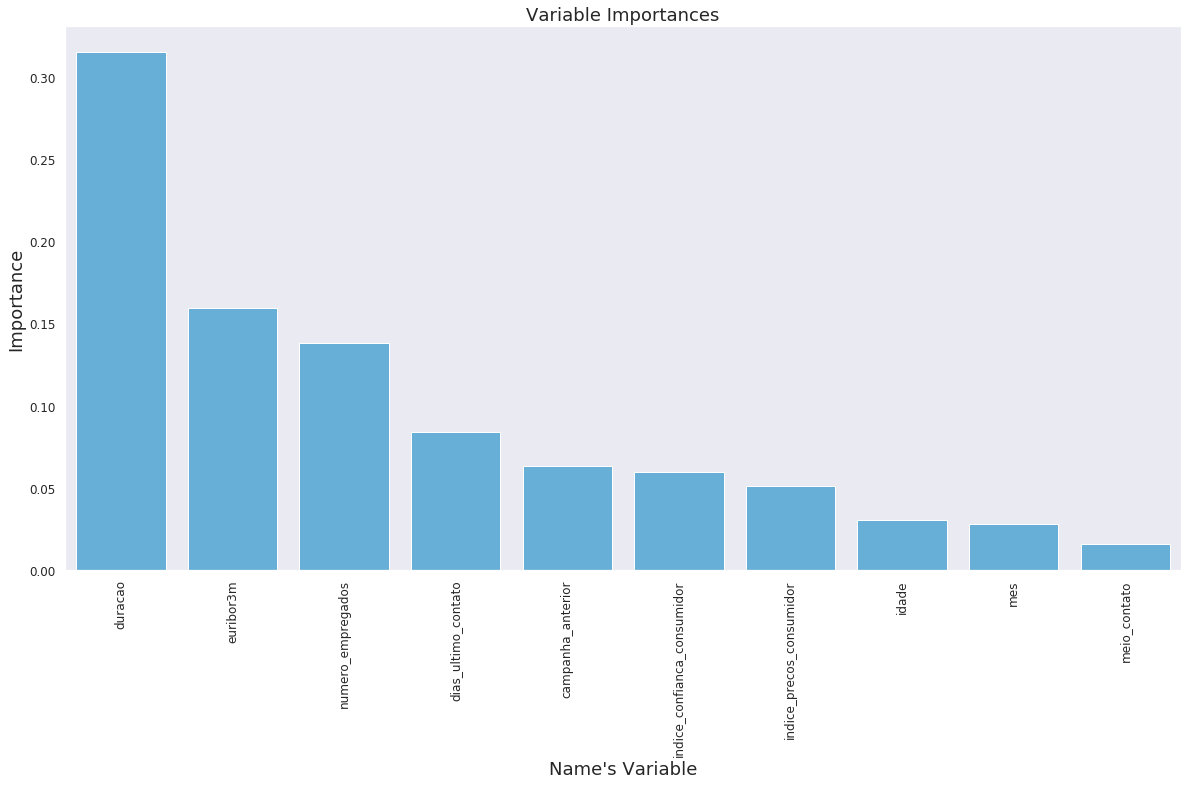

In [14]:
fig,ax = plt.subplots()
plt.xticks(rotation='vertical')

fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10], 
            x="feature", 
            y="importance", 
            ax=ax,
            color=default_color)
ax.set(xlabel="Name's Variable",
       ylabel='Importance',
       title="Variable Importances")

## Training and Testing Dataset
- métrica: cross score

In [15]:
def cross_val_model(X,y, model, n_splits=3):
    'Do split dataset and calculate cross_score'
    print("Begin training", end='\n\n')
    start = time.time()
    
    X = np.array(X)
    y = np.array(y)
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("\tcross_score: %.5f" % cross_score.mean())
    
    end = time.time()
    print("\nTraining done! Time Elapsed:", end - start, " seconds.")

In [16]:
# training model

X = df_callcenter[list_without_target_col]
y = df_callcenter['resultado'] # target

---

## Modelos de Previsão
- Modelo Baseline
- Benckmarks

### Modelo Baseline
- Vou começar com um baseline, sendo o mais simples possível.

#### Linear Regression

In [17]:
# Visualize params

LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
# create model
lr_model = LinearRegression(n_jobs=-1, normalize=False)

# training model
X = df_callcenter[list_without_target_col]
y = df_callcenter['resultado']

In [19]:
# split dataset and calculate cross_score
cross_val_model(X, y, lr_model)

Begin training

Fit LinearRegression fold 1
	cross_score: 0.80264
Fit LinearRegression fold 2
	cross_score: 0.82961
Fit LinearRegression fold 3
	cross_score: 0.81311

Training done! Time Elapsed: 0.16795086860656738  seconds.


### Benckmarks

#### RandomForest

In [20]:
# Visualize params

RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
# RandomForest params dict
rf_params_one = {}

rf_params_one['n_estimators'] = 10
rf_params_one['max_depth'] = 10
rf_params_one['min_samples_split'] = 10
rf_params_one['min_samples_leaf'] = 10 # end tree necessary 30 leaf
rf_params_one['n_jobs'] = -1 # run all process

In [22]:
# create model
rf_model_one = RandomForestClassifier(**rf_params_one)

# training model
X = df_callcenter[list_without_target_col]
y = df_callcenter['resultado']

In [23]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_model_one)

Begin training

Fit RandomForestClassifier fold 1
	cross_score: 0.25745
Fit RandomForestClassifier fold 2
	cross_score: 0.24808
Fit RandomForestClassifier fold 3
	cross_score: 0.27753

Training done! Time Elapsed: 2.6185479164123535  seconds.


In [24]:
# RandomForest params dict
rf_params_two = {}

rf_params_two['n_estimators'] = 1
rf_params_two['max_depth'] = 2
rf_params_two['min_samples_split'] = 2
rf_params_two['min_samples_leaf'] = 18 # end tree necessary 30 leaf
rf_params_two['n_jobs'] = -1 # run all process

In [25]:
# create model
rf_model = RandomForestClassifier(**rf_params_two)

# training model
X = df_callcenter[list_without_target_col]
y = df_callcenter['resultado']

In [27]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_model)

Begin training

Fit RandomForestClassifier fold 1
	cross_score: 0.53090
Fit RandomForestClassifier fold 2
	cross_score: 0.60888
Fit RandomForestClassifier fold 3
	cross_score: 0.35173

Training done! Time Elapsed: 0.47402286529541016  seconds.


#### Random Forest Regressor

In [31]:
# Visualize params

RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
# 1st model Random Forest
rf_regressor_one = RandomForestRegressor(n_estimators = 1, 
                                         n_jobs = -1,
                                         verbose = 0, 
                                         max_depth = 10)

In [33]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_regressor_one)

Begin training

Fit RandomForestRegressor fold 1
	cross_score: 0.63608
Fit RandomForestRegressor fold 2
	cross_score: 0.65961
Fit RandomForestRegressor fold 3
	cross_score: 0.69218

Training done! Time Elapsed: 0.5538980960845947  seconds.


In [45]:
# 2st model Random Forest
rf_regressor_two = RandomForestRegressor(n_estimators = 500, 
                                         n_jobs = -1,
                                         verbose = 0, 
                                         max_depth = 10)

In [46]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_regressor_two)

Begin training

Fit RandomForestRegressor fold 1
	cross_score: 0.72450
Fit RandomForestRegressor fold 2
	cross_score: 0.80444
Fit RandomForestRegressor fold 3
	cross_score: 0.84793

Training done! Time Elapsed: 28.019280433654785  seconds.


---

## Escolha do Melhor Modelo

Baseado no cross_score o modelo escolhido será **random forest regressor** com os parâmetros do 2º modelo, que obteve um score > 0.84.